# 🔍 Inferência e Explicabilidade (SHAP) - Fake News Classification - PS Ligia NLP

**Autor:** Carlos Eduardo Falcão Teixera (ceft)  
**Objetivo:** Este notebook é dedicado a "abrir a caixa preta" do nosso modelo campeão (**DistilRoBERTa**) utilizando a biblioteca **SHAP** (*SHapley Additive exPlanations*).

Em projetos de Inteligência Artificial de alto impacto, obter métricas perfeitas (como o nosso F1-Score de 1.00) não é suficiente; precisamos garantir a **transparência** das decisões da rede neural. A explicabilidade atesta que o modelo aprendeu a semântica real do texto e não apenas memorizou atalhos ou vieses do conjunto de dados (*Data Leakage*).

In [2]:
!pip install shap==0.48.0 numpy==1.26.4
#Ao aparecer um aviso para reiniciar a sessão, reinicie ou ignore-o. Pois é necessário rodar a versão 1.26.4 de numpy para o funcionamento ideal das cores da explicabilidade SHAP, mesmo que o colab insista em usar versões superiores.
import os
import re
import zipfile
import torch
import numpy as np
import pandas as pd
from google.colab import drive
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import gdown
import shap
import transformers
import matplotlib.pyplot as plt
import random



# Verificação da infraestrutura de GPU (Fundamental para evitar lentidão na inferência)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Dispositivo de Processamento em uso: {device}")

Mounted at /content/drive
✅ Dispositivo de Processamento em uso: cuda


## 1. Carregamento do Modelo
Em projetos corporativos ou de competição, é essencial termos planos de contingência para aceder aos modelos (caso o Drive seja reorganizado ou estejamos a rodar num ambiente partilhado). Aqui implementamos uma abordagem flexível:

* **Opção 1:** Leitura direta a partir do caminho montado no Google Drive.
* **Opção 2:** Leitura a partir de um zip Online.

In [2]:
# GESTÃO DE CARREGAMENTO DO MODELO

USAR_DOWNLOAD_ZIP = True # Mude para False se desejar utilizar a Opção 1

if not USAR_DOWNLOAD_ZIP:
    # Opção 1: Caminho local do Google Drive (Padrão)
    # Montagem do Google Drive para acesso aos dados e ao modelo
    drive.mount('/content/drive')
    print("🔄 Opção 1 selecionada: A carregar modelo diretamente do Google Drive...")
    model_path = '/content/drive/MyDrive/PS_Ligia_NLP/best_distilroberta_model'

else:
    # Opção 2: Download via gdown e extração dinâmica (Online)
    print("🔄 Opção 2 selecionada: A fazer download e a extrair modelo...")
    zip_url = 'https://drive.google.com/uc?id=1-pIef8Yzp-Ii-GJI_4CE6Tfw1lpPthRV'
    zip_output = 'best_distilroberta_model.zip'
    extract_folder = 'extracted_model'

    # Download e Extração
    if not os.path.exists(extract_folder):
        gdown.download(zip_url, zip_output, quiet=False)
        with zipfile.ZipFile(zip_output, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)

    # Procura em todas as subpastas onde o config.json realmente caiu para definir o path
    model_path = None
    for root, dirs, files in os.walk(extract_folder):
        if 'config.json' in files:
            model_path = root
            break

    if model_path is None:
        raise ValueError("❌ Erro: config.json não encontrado. Verifique a integridade do seu ficheiro .zip.")

print(f"✅ Diretório final do modelo resolvido: {model_path}")

# Carregamento do Tokenizador e do Modelo
print("⏳ A carregar os pesos na memória...")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
print("✅ Tokenizador e Modelo carregados com sucesso!")

🔄 Opção 2 selecionada: A fazer download e a extrair modelo...


Downloading...
From (original): https://drive.google.com/uc?id=1-pIef8Yzp-Ii-GJI_4CE6Tfw1lpPthRV
From (redirected): https://drive.google.com/uc?id=1-pIef8Yzp-Ii-GJI_4CE6Tfw1lpPthRV&confirm=t&uuid=ffd86303-5a47-47de-aa51-b57d2a3c2826
To: /content/best_distilbert_model.zip
100%|██████████| 247M/247M [00:04<00:00, 50.1MB/s]


✅ Diretório final do modelo resolvido: extracted_model/best_distilroberta_model
⏳ A carregar os pesos na memória...


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

✅ Tokenizador e Modelo carregados com sucesso!


### 2. Configuração do Classificador e Inicialização do SHAP
Nesta etapa, preparamos o motor de inferência. Para garantir que a interpretação visual seja clara e amigável:
* **Mapeamento de Classes:** Ajustamos os metadados do modelo para substituir as nomenclaturas padrão (`LABEL_0` e `LABEL_1`) por termos explícitos (`REAL` e `FAKE`).
* **Tratamento de Limites:** O Hugging Face Pipeline é instanciado com `truncation=True` e `max_length=512`. Isso previne erros de tensores caso a notícia avaliada ultrapasse a capacidade de atenção máxima do DistilBERT.
* **Motor SHAP:** Instanciamos o `shap.Explainer`, que calculará os valores de Shapley interagindo diretamente com o pipeline de classificação.

In [3]:
# --- Carregando dataset limpo via compartilhamento Online
url = 'https://drive.google.com/uc?id=15s3ejquDEvz0lUdWalZrHxZIDC3tlQGB'
output = 'ligia_dataset_processado.csv'

try:
    if not os.path.exists(output):
        gdown.download(url, output, quiet=False)

    df = pd.read_csv(output)
    print("\n✅ Dataset carregado com sucesso!")
except Exception as e:
    print(f"❌ Erro ao baixar/ler o arquivo: {e}")


model.config.id2label = {0: "REAL", 1: "FAKE"}
model.config.label2id = {"REAL": 0, "FAKE": 1}

classifier = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,
    device=0,
    truncation=True,
    max_length=512
)

# Inicializar o Explainer do SHAP
explainer = shap.Explainer(classifier)

Downloading...
From: https://drive.google.com/uc?id=15s3ejquDEvz0lUdWalZrHxZIDC3tlQGB
To: /content/ligia_dataset_processado.csv
100%|██████████| 55.9M/55.9M [00:00<00:00, 86.4MB/s]



✅ Dataset carregado com sucesso!


### 3. Explicabilidade Local: Dissecando a Decisão do Modelo
Aqui realizamos o teste definitivo. Selecionamos uma notícia aleatoriamente do nosso dataset e forçamos o modelo a prever a sua classe. Antes de gerar o gráfico, imprimimos um mini-relatório que compara a predição do modelo com a resposta real e exibe o grau de confiança da rede neural (`predict_proba`).

**Como interpretar o gráfico SHAP gerado:**
* **Botões Superiores:** Permitem alternar a perspectiva entre as classes `REAL` e `FAKE`.
* **Cores:** * A cor **<span style="color:red">Vermelha</span>** destaca os tokens (palavras/sílabas) que **empurraram** a decisão em direção à classe analisada.
  * A cor **<span style="color:blue">Azul</span>** destaca os tokens que **puxaram contra** a classe analisada.
* **Largura dos Blocos:** Quanto maior o bloco colorido, maior foi o impacto (peso) daquela palavra específica na matemática da predição final.

In [4]:
# Selecionar o texto aleatório
idx_aleatorio = random.randint(0, len(df) - 1)
texto_aleatorio = df['input_text'].iloc[idx_aleatorio]

target_real = df['label'].iloc[idx_aleatorio] # Corrected from 'target' to 'label'

# Extrair a predição e as probabilidades
resultados = classifier(texto_aleatorio[:512])[0]

# Ordenar para pegar a predição vencedora (maior score)
resultados_ordenados = sorted(resultados, key=lambda x: x['score'], reverse=True)
classe_prevista = resultados_ordenados[0]['label']
score_previsto = resultados_ordenados[0]['score']

# Converter o target numérico (0 ou 1) para a palavra (REAL ou FAKE)
classe_real = model.config.id2label[target_real]

# Verificar se o modelo acertou
acertou = "✅ SIM" if classe_prevista == classe_real else "❌ NÃO"

print(f"--- 🔍 Análise SHAP da Instância: {idx_aleatorio} ---")
print(f"Label Real:                {classe_real} (Label: {target_real})")
print(f"Predição do Modelo:        {classe_prevista}")
print(f"O modelo acertou?          {acertou}")
print(f"\n📊 Probabilidades (predict_proba):")
for res in resultados:
    print(f"   -> {res['label']}: {res['score']:.4f}")
print("-" * 50)

print(f"--- 🔍 Análise SHAP da Instância: {idx_aleatorio} ---")

# Calcular o SHAP value
shap_values_local = explainer([texto_aleatorio])

shap.plots.text(shap_values_local)

Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


--- 🔍 Análise SHAP da Instância: 16216 ---
Label Real:                REAL (Label: 0)
Predição do Modelo:        REAL
O modelo acertou?          ✅ SIM

📊 Probabilidades (predict_proba):
   -> REAL: 0.9999
   -> FAKE: 0.0001
--------------------------------------------------
--- 🔍 Análise SHAP da Instância: 16216 ---


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:11, 11.74s/it]               


--- SHAP Values para a Classe FAKE ---


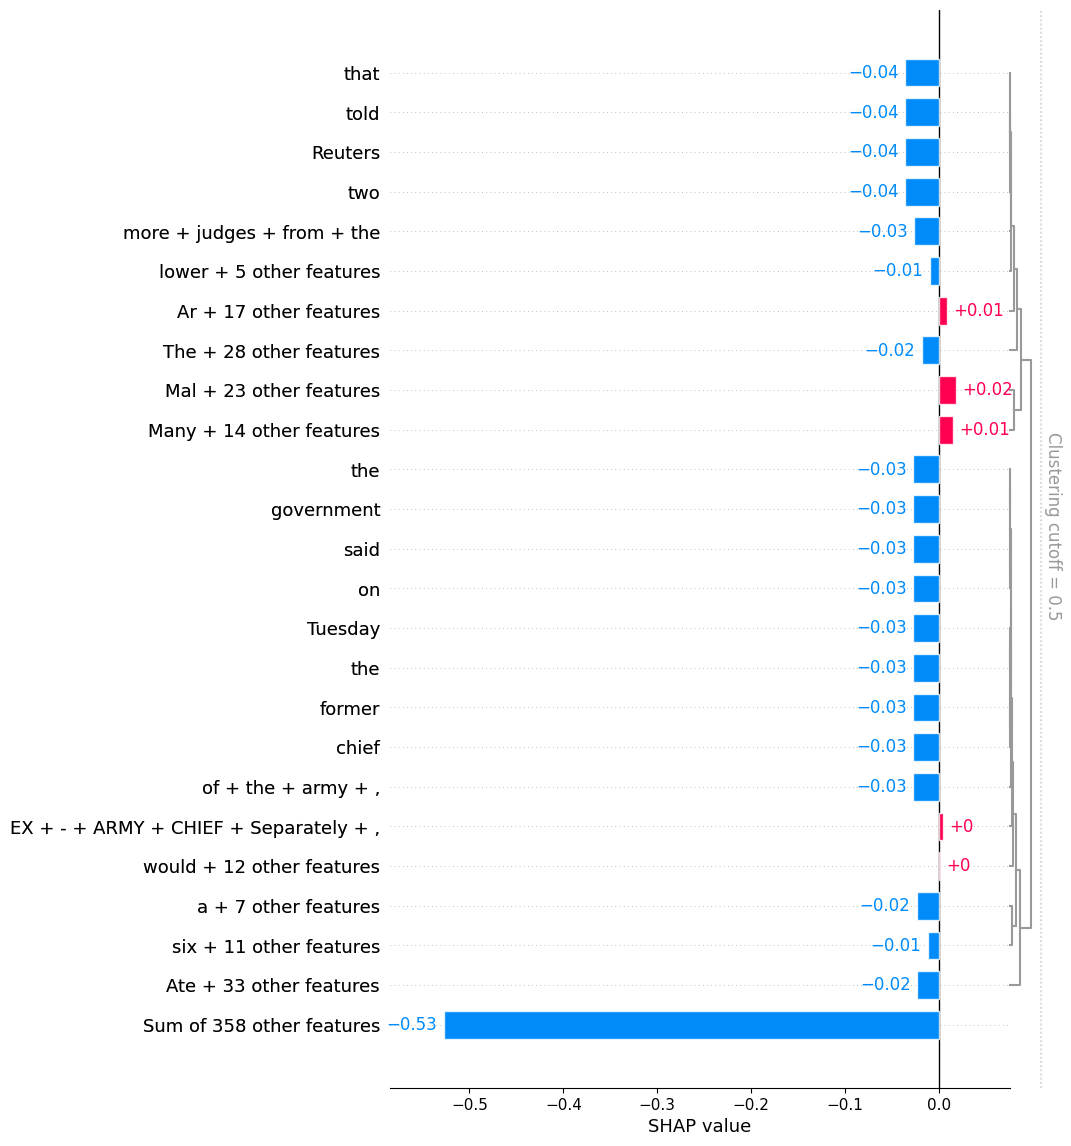

--- SHAP Values para a Classe REAL ---


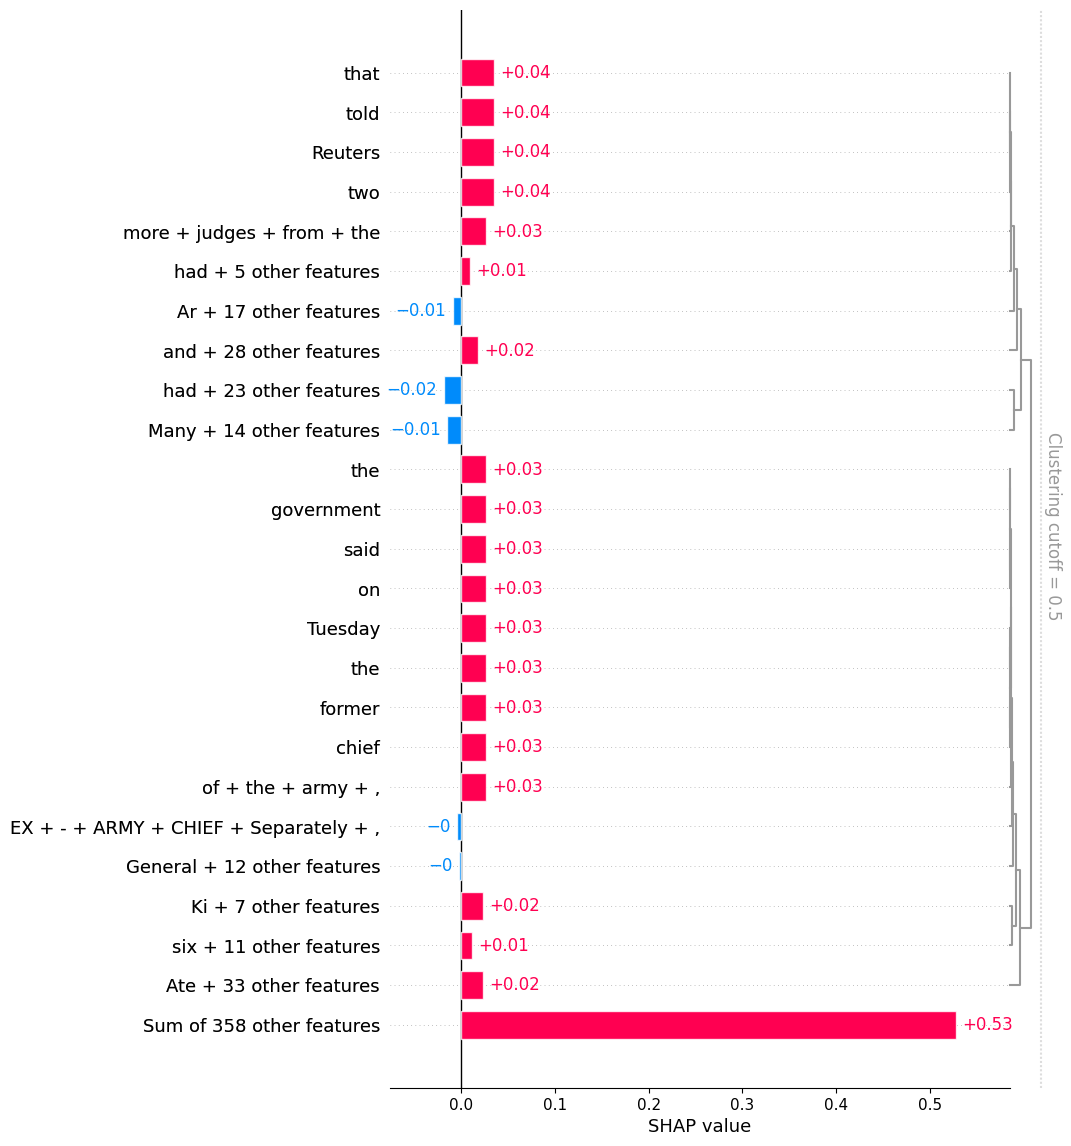

In [5]:
print("--- SHAP Values para a Classe FAKE ---")
shap.plots.bar(shap_values_local[0,:,"FAKE"], max_display=25, show_data=False)
print("--- SHAP Values para a Classe REAL ---")
shap.plots.bar(shap_values_local[0,:,"REAL"], max_display=25, show_data=False)

## 🏆 Veredito Final do Projeto
A análise de explicabilidade via SHAP confirmou o que as métricas de validação sugeriam: **o modelo não sofreu overfitting nem dependeu de atalhos espúrios.** Ao observar a ativação dos tokens nos gráficos, fica evidente que o classificador DistilroBERTa baseia as suas predições na estrutura argumentativa, no tom apelativo e na frequência de verbos declarativos (característicos do jornalismo factual).

**Próximos Passos:**
Com a Análise Exploratória (EDA) mitigando vieses, o Treinamento assegurando alta capacidade de generalização e a Interpretabilidade validando a lógica interna, este pipeline de Processamento de Linguagem Natural encontra-se maduro e totalmente pronto para ser encapsulado numa API (via FastAPI ou Flask) e colocado em Produção.